In [127]:
# This notebook runs a test code
import numpy as np
import matplotlib.pyplot as plt
import random 

from scipy import interpolate

# load in custom library
import lunar_processes as pr
from lunar_processes import G, moonM, moonR
# for testing time
import time

In [146]:


# Establish run parameters
# Initial longitude of noon
local_noon = 0

# Run time in lunar hours
t = 24

# Size of time step in lunar hours
dt = 0.25 

# Number of particles
n = 1000

# establish particles
particles = np.zeros((n, 3)) # latitude, longitude,  tod
particles[:, 0] = np.deg2rad(random.choices(range(-90, 90), k=n)) # latitude in degrees
particles[:, 1] = np.deg2rad(random.choices(range(0, 360), k=n)) # longitude in degrees
particles[:, 2] = (12+(((np.rad2deg(particles[:, 1]-local_noon))*24)/360))%24 # tod, based on where local noon is


def ballistic_tof(vm, phi):
    # Butler 1997

    voy = vm*np.sin(phi)             # m/s
    
    g0 = G*moonM/moonR**2                # m/s2
    hmax = (moonR * voy**2)/ (moonR*2*g0 - voy**2)   # m ?
    
    # now find the time of flight
    v = moonR + hmax           # give this a new lettter
    g = (G*moonM)/((moonR)**2) #(G*moonM)/((moonR+hmax)**2)
    a = voy**2 * moonR
    b = voy**2 - 2*g*moonR
    
    u = a+b*hmax  
    l = a - b*moonR
    p = (2*b*hmax+a+(b*moonR))/l
    
    t =  ((v/np.abs(v))*(np.sqrt(u*v)/b + l/(2*b)*((1/np.sqrt(-b))*np.arcsin(p)))) # at hmax
    
    v = moonR 
    g = G*moonM/moonR**2
    a = voy**2 * moonR
    b = voy**2 - 2*g*moonR
    
    u = a+b*0
    l = a - b*moonR
    p = (2*b*0+a+(b*moonR))/l
    t0 =  ((v/np.abs(v))*(np.sqrt(u*v)/b + l/(2*b)*((1/np.sqrt(-b))*np.arcsin(p)))) # at0
    
    time_of_flight = 2*(t-t0)
    
    hmax = (moonR*voy**2)/(2*moonR*g-voy**2)

    # if hmax > 6.15*10**7: #equation: a*(moonM/3*earthM)**(1/3); where a = 384400 km, 
        # raise Exception("exceed's hill sphere!")
        # print("hmax:", hmax)
    return time_of_flight, hmax 

# run
temp = np.zeros((n))
launch = np.zeros((n))
f_tof = np.zeros((n))
particle_v = np.zeros((n))
height = np.zeros((n))
# start timer
st = time.time()

R_bar = pr.R/(pr.m_H2O/1000)
pMass = pr.mass
# Run model for n particles, 1 lunar day time step 1/2 hr (lunar)
for i in range(0, n, 1):
    temp[i], n = pr.DivinerT(particles[i, 0], particles[i, 1], particles[i, 2], pr.data)
    direction, launch[i] = pr.random_vals() 
    #results[0:3, i+1], f_tof, distm, condc = ballistic(results[3, i], results[0, i], results[1, i], results[2, i], direction, launch, pMass, vel_dist)
    s1 = pr.maxwell_boltz_dist(pr.vel_dist, pMass, temp[i])
    particle_v[i] = random.choices(pr.vel_dist, weights=s1/np.nanmax(s1))[0]  
    
    if particle_v[i] > pr.vesc:
       raise Exception("particle escapes - Jeans")
    
    f_tof[i], height[i] = ballistic_tof(particle_v[i], launch[i])
    if np.isnan(f_tof[i]) == True:
        f_tof[i] = pr.nan_tof(particle_v[i], launch[i])
        print("Issue in TOF equation")
    if height[i] > 6.15*10**7:
        raise Exception("particle escapes - Hills")
        
    if i % 10 ==0:
            print('particle', i)

print('Total simulation time: %2.1f'%(time.time() - st))

print('Lunar time step: %3.2e'%(pr.sec_per_hour_M*dt))

particle 0


KeyboardInterrupt: 

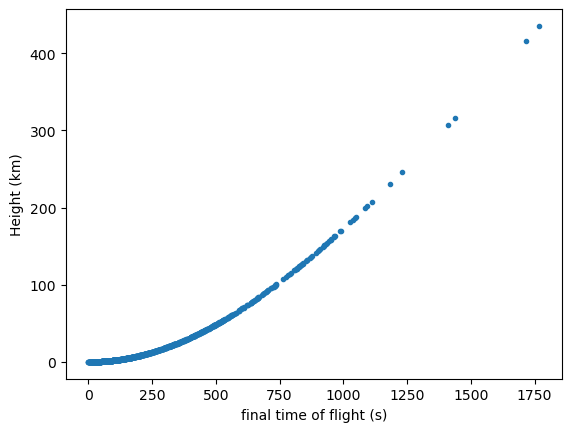

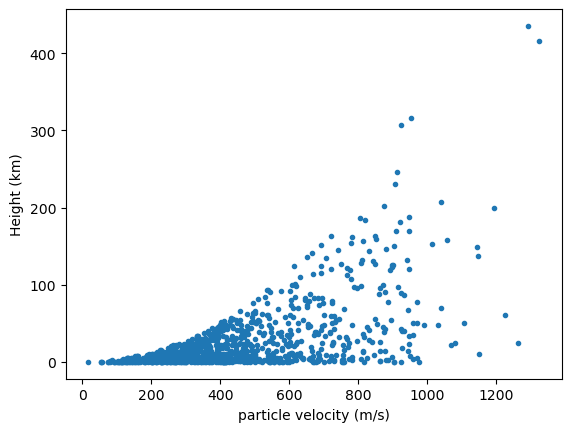

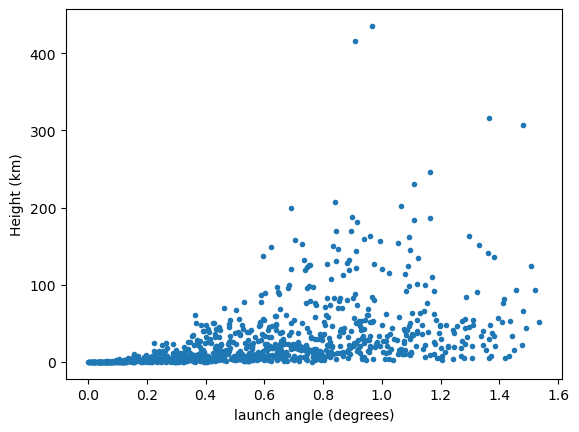

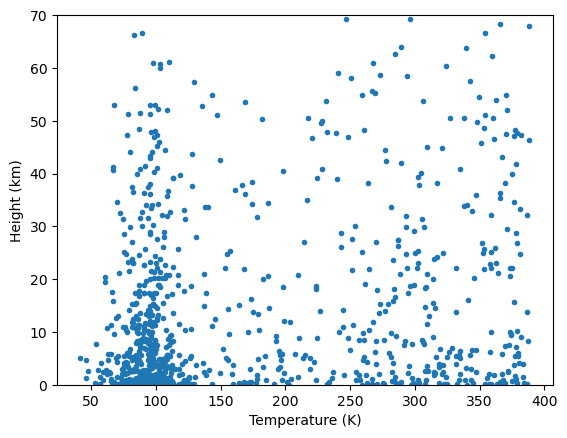

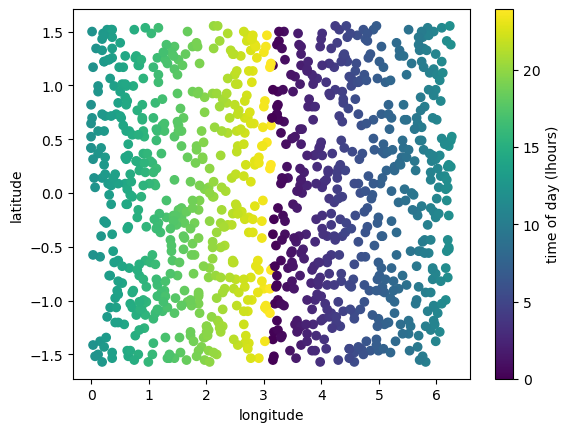

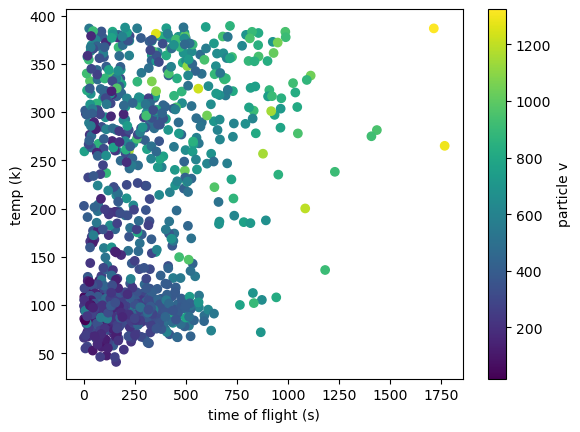

In [26]:
plt.plot(f_tof, height/1000,'.')
#plt.hlines(6.15*10**7, 0, np.nanmax(f_tof))
plt.ylabel("Height (km)")
plt.xlabel("final time of flight (s)")
plt.show()

plt.plot(particle_v, height/1000,'.')
#plt.hlines(6.15*10**7, 0, np.nanmax(f_tof))
plt.ylabel("Height (km)")
plt.xlabel("particle velocity (m/s)")
plt.show()

plt.plot(launch, height/1000,'.')
#plt.hlines(6.15*10**7, 0, np.nanmax(f_tof))
plt.ylabel("Height (km)")
plt.xlabel("launch angle (degrees)")
plt.show()

plt.plot(temp, height/1000,'.')
#plt.hlines(6.15*10**7, 0, np.nanmax(f_tof))
plt.ylim((0, 70))
plt.ylabel("Height (km)")
plt.xlabel("Temperature (K)")
plt.show()

plt.scatter(particles[:, 1], particles[:, 0], c=particles[:, 2])
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.colorbar(label="time of day (lhours)")
plt.show()

plt.scatter(f_tof, temp, c=particle_v)
plt.colorbar(label="particle v")
plt.ylabel("temp (k)")
plt.xlabel("time of flight (s)")
plt.show()

Average time of flight:  280.289141050906


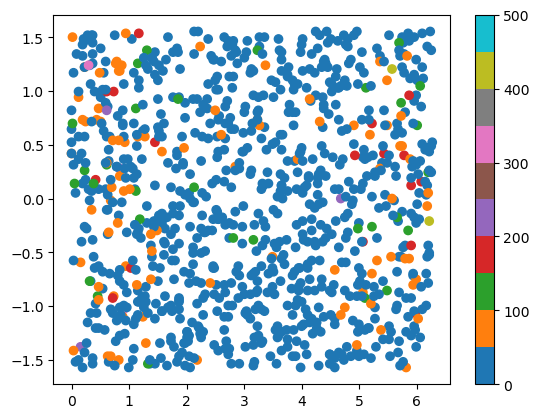

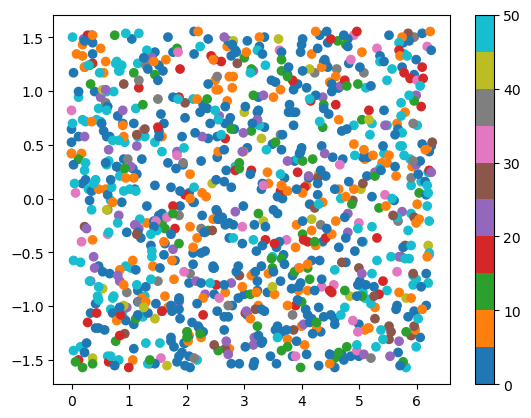

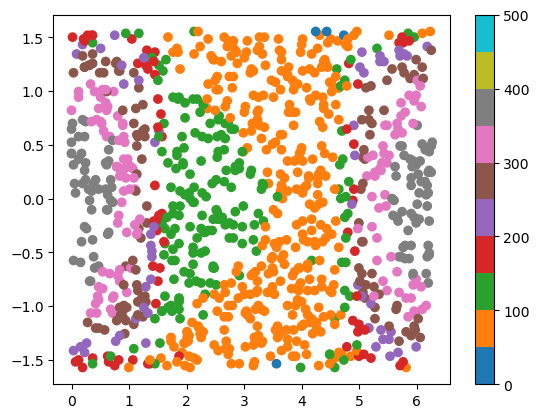

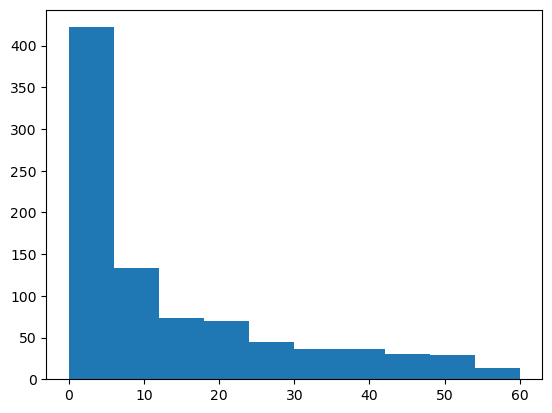

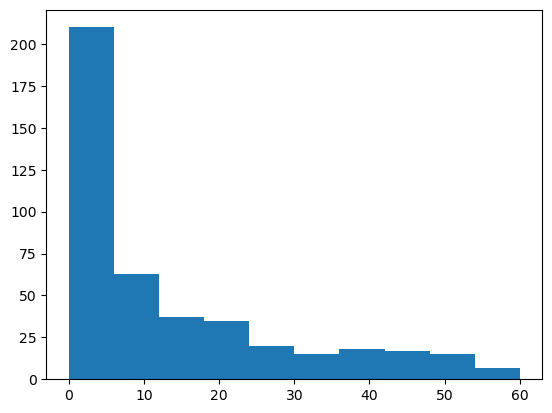

498


In [61]:
# given these 1000 particles, calculate:
# 1. how many are in the exopshere at a time
# 2. the height distribution at a time
# 3. how does this change after the first hop? (loss, change in time and temp) 
# 4. average hop time ? should be in outputs

print("Average time of flight: ", np.nanmean(f_tof))

plt.scatter(particles[:, 1], particles[:, 0], c=height/1000, vmin=0, vmax= 500, cmap='tab10')
plt.colorbar()
plt.show()

plt.scatter(particles[:, 1], particles[:, 0], c=height/1000, vmin=0, vmax= 50, cmap='tab10')
plt.colorbar()
plt.show()

plt.scatter(particles[:, 1], particles[:, 0], c=temp, vmin=0, vmax= 500, cmap='tab10')
plt.colorbar()
plt.show()

plt.hist(height/1000, bins=10, range=(0, 60))
plt.show()

day = np.argwhere((particles[:, 2] > 6) & (particles[:, 2] < 18))
plt.hist(height[~day]/1000, bins=10, range=(0, 60))
plt.show()
print(np.size(day))


In [1]:
zeros = np.argwhere(height < 1000 b)


SyntaxError: invalid syntax (1620907116.py, line 1)

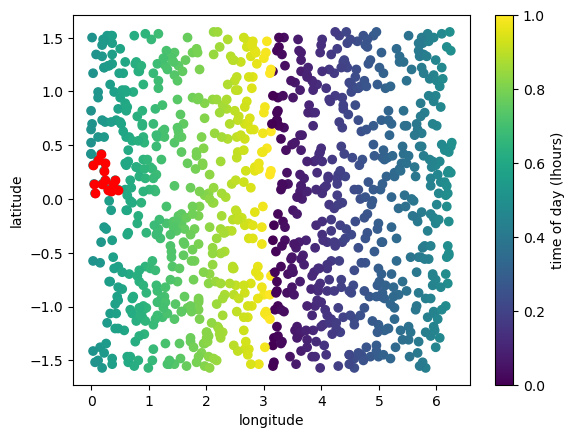

14


(array([7., 0., 1., 2., 0., 0., 0., 2., 1., 1.]),
 array([  0.25699148,  15.36650512,  30.47601876,  45.58553239,
         60.69504603,  75.80455967,  90.9140733 , 106.02358694,
        121.13310057, 136.24261421, 151.35212785]),
 <BarContainer object of 10 artists>)

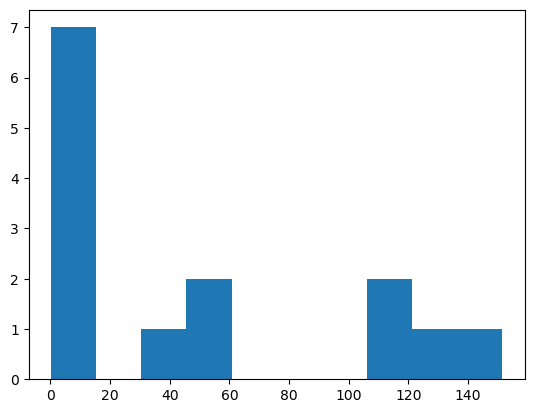

In [58]:
box = np.argwhere((0.0 < particles[:, 0]) & (particles[:, 0] < 0.5) & (0 < particles[:, 1]) &(particles[:, 1] < 0.5))

plt.scatter(particles[:, 1], particles[:, 0], c=particles[:, 2])
plt.scatter(particles[:, 1][box], particles[:, 0][box], c='r')

plt.ylabel('latitude')
plt.xlabel('longitude')
plt.colorbar(label="time of day (lhours)")
plt.show()

print(np.size(box))

plt.hist(height[box]/1000)

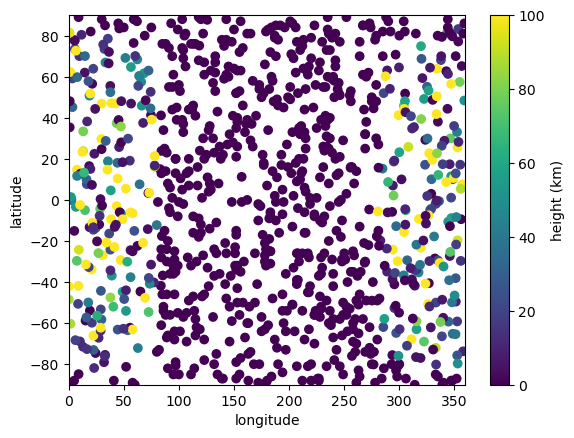

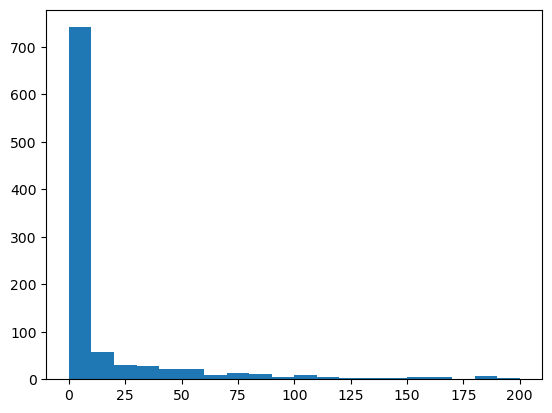

633


In [159]:
#### check how often they are going through more than one hop (18/192, takes two hops)
#multi_hops = np.argwhere(results[:, 6, :] > 1)
# what am i trying to learn? how many particles are in the air at one time
tt = 1
plt.scatter(np.rad2deg(results[:, 1, tt]), np.rad2deg(results[:, 0, tt]), c=results[:, 8, tt]/1000, cmap='viridis', vmin=0, vmax=100)
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.ylim((-90, 90))
plt.xlim((0, 360))
plt.colorbar(label='height (km)')
plt.show()

plt.hist(results[:, 8, tt]/1000, bins=20, range=(0, 200))
plt.show()

print(np.size(np.argwhere(results[:, 8, tt] == 0)))


[ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.
  0.  1.  2.  2.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0. nan  1.  0.  1.  0.  0.
  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  2.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.
  1.  1.  2.  1.  1.  0.  1.  0.  0.  0.  1.  0.  1

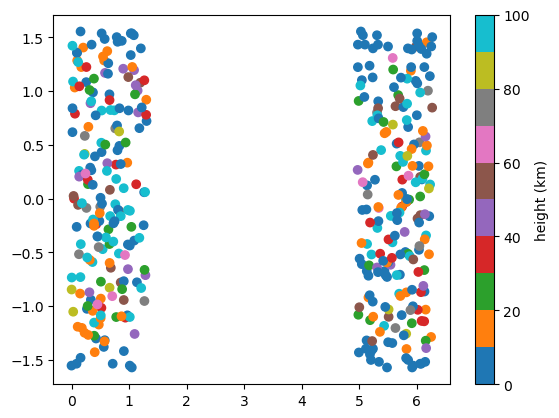

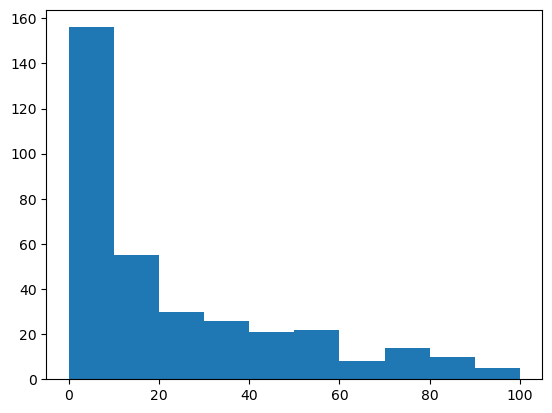

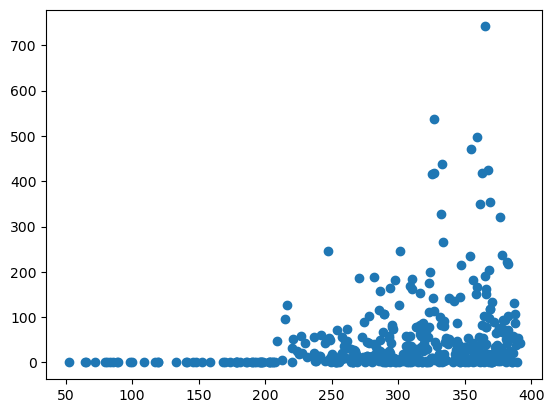

In [449]:
##### day = np.argwhere((results[:, 2, tt] > 7) & (results[:, 2, tt] < 17))
print(results[:, 6, 1])
day_values = results[day, :, tt].reshape((np.size(day), 9))

plt.scatter(day_values[:, 1], day_values[:, 0], c=day_values[:, 8]/1000, vmin=0, vmax=100, cmap='tab10')
plt.colorbar(label='height (km)')
plt.show()

plt.hist(day_values[:, 8]/1000, range=(0, 100), bins=10)
plt.show()

plt.scatter(day_values[:, 3], day_values[:, 8]/1000)
plt.show()

2126.16 106308.0
50.0


/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_24506/2001831922.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.arange(0, t/dt, 1), results[i, 8, :]/1000, s=2, c=color[i])


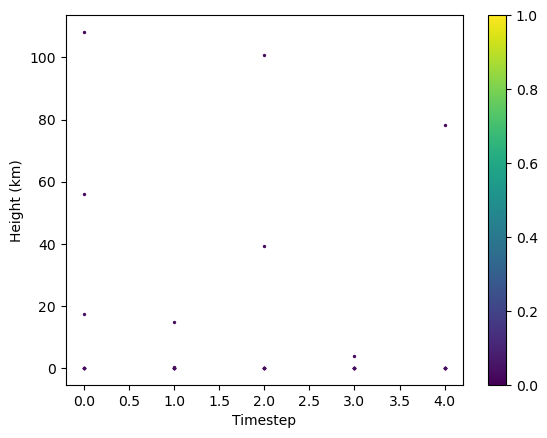

[     0.              0.              0.         108209.58430766
      0.              0.              0.          55936.16072651
      0.          17265.19606375]


In [152]:
# maybe do a small loop (~half a lunar hour, timestep of .... 250 seconds)
# but keep track of height distribution. and then plot ? 

# Initial longitude of noon
local_noon = 0

# Run time in lunar hours
t = 0.1

# Size of time step in lunar hours
dt = 0.02

# Number of particles
n = 1000

# run
results = np.zeros((n, 9, int(t/dt)))

# start timer
st = time.time()

# Run model for n particles, 1/2 lunar hour with timestep of 250 seconds
for i in range(0, n, 1):
    results[i, :, :] = Model_MonteCarlo(particles[i, :], dt, t, local_noon)
    #if i % 10 ==0:
    print('particle', i)

print('Total simulation time: %2.1f'%(time.time() - st))

print('Lunar time step: %3.2e'%(pr.sec_per_hour_M*dt))


particle 0
particle 1
particle 2
particle 3
particle 4
particle 5
particle 6
particle 7
particle 8
particle 9


/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_24506/1653286271.py:39: RuntimeWarning: invalid value encountered in sqrt
  t =  ((v/np.abs(v))*(np.sqrt(u*v)/b + l/(2*b)*((1/np.sqrt(-b))*np.arcsin(p)))) # at hmax
/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_24506/1653286271.py:39: RuntimeWarning: invalid value encountered in arcsin
  t =  ((v/np.abs(v))*(np.sqrt(u*v)/b + l/(2*b)*((1/np.sqrt(-b))*np.arcsin(p)))) # at hmax


nan,  18481.268984299848
particle 10
particle 11
particle 12
particle 13
particle 14
particle 15
particle 16
particle 17
particle 18
particle 19
particle 20
particle 21
particle 22
nan,  35122.27302102486
particle 23
particle 24
particle 25
particle 26
particle 27
particle 28
particle 29
particle 30
particle 31
particle 32
particle 33
particle 34
particle 35
particle 36
particle 37
particle 38
nan,  39578.529564785094
particle 39
particle 40
particle 41
particle 42
particle 43
particle 44
particle 45
particle 46
particle 47
particle 48
particle 49
particle 50
particle 51
particle 52
particle 53
particle 54
particle 55
particle 56
particle 57
nan,  39660.14746165879
particle 58
particle 59
particle 60
particle 61
particle 62
particle 63
nan,  677.4313719389594
particle 64
particle 65
nan,  1415.1375607909627
particle 66
particle 67
particle 68
particle 69
particle 70
particle 71
particle 72
particle 73
particle 74
particle 75
particle 76
particle 77
particle 78
particle 79
particle 80
p

particle 538
particle 539
nan,  10536.74139990723
particle 540
particle 541
nan,  1059.2132341901895
particle 542
particle 543
particle 544
nan,  38322.650415267366
particle 545
particle 546
particle 547
particle 548
particle 549
particle 550
particle 551
nan,  5181.033074477175
particle 552
particle 553
particle 554
particle 555
particle 556
particle 557
particle 558
particle 559
particle 560
particle 561
particle 562
particle 563
particle 564
particle 565
particle 566
particle 567
particle 568
particle 569
particle 570
particle 571
nan,  41448.915781547694
nan,  36195.45196247002
particle 572
particle 573
particle 574
nan,  185389.90944103908
particle 575
particle 576
particle 577
particle 578
nan,  10219.21826903162
particle 579
particle 580
particle 581
particle 582
particle 583
particle 584
particle 585
particle 586
particle 587
particle 588
particle 589
particle 590
particle 591
particle 592
particle 593
particle 594
particle 595
particle 596
particle 597
particle 598
particle 59

In [151]:
#%% outputting height with smooth moon model
def nan_tof(vm, phi):
    vtest = np.arange(vm-100, vm+100, 1)
    vm_loc = np.argwhere(vtest == vm)[0][0]
    time, height = ballistic_tof(vtest, phi)
    
    mask = np.isnan(time)
    spline = interpolate.InterpolatedUnivariateSpline(vtest[~mask], time[~mask])
    time_new = spline(vtest)
    
    voy = vm*np.sin(phi) 
    g = (pr.G*pr.moonM)/((pr.moonR)**2)
    height = (pr.moonR*voy**2)/(2*moonR*g-voy**2)
    return time_new[vm_loc], height

def ballistic(temp, i_lat, i_long, i_tod, direction, launch, pMass, vel_dist):

    s1 = pr.maxwell_boltz_dist(pr.vel_dist, pMass, temp)

    particle_v = random.choices(vel_dist, weights=s1/np.nanmax(s1))[0]  
    cond = False
    if particle_v > pr.vesc:
       cond = True

    dist_m = pr.ballistic_distance(launch, moonR, particle_v, moonM)
    f_lat, f_long = pr.landing_loc(i_lat, i_long, dist_m, moonR, direction)
    f_tof, height = ballistic_tof(particle_v, launch)
    
    if np.isnan(f_tof) == True:
        f_tof, height = nan_tof(particle_v, launch)
    
    f_tod = pr.time_of_day(i_long, f_long, i_tod, f_tof)
    return np.array([f_lat, f_long, f_tod]), f_tof, height, dist_m, cond

def Model_MonteCarlo(particle, dt, t, local_noon):
    R_bar = pr.R/(pr.m_H2O/1000)
    pMass = pr.mass
    sigma_Sputtering = pr.sput_lifespan_G19
    photo_lifespan =  pr.photo_lifespan_S14

    # results array
    results = np.zeros((9, int(t/dt)+1))*np.nan # (lat, long, tod, temp, exists, total time, hops, dist, height), 2rd is time
    
    # if exists = True, set 1. Else, set 0
    
    i = 0
    results[0:3, 0] = particle
    results[4, 0] = False
    conda = False
    condb = False
    condc = False
    
    lunar_dt = pr.sec_per_min_M*dt
    #lunar_dt = sec_per_hour_M*dt

    # let particle run for 1 lunar rotation
    for i in range(0, int(t/dt), 1):
        st_time = time.time()
        # find initial temperature from location
        results[3, i], n = pr.DivinerT(results[0, i], results[1, i], results[2, i], pr.data)
        
        # define how long it sits for
        tau_surf = pr.surftime(R_bar, results[3, i], pMass)  

        # if it sits for a timestep, test lost, then move to next timestep
        if tau_surf >= lunar_dt:
            conda = pr.loss(sigma_Sputtering, photo_lifespan, lunar_dt, results[2, i])
            if conda == True:
                #print('Particle is lost from sitting')
                results[4, i] = conda
                break
            else:
                #print('Particle is not lost from sitting')
                results[0:3, i+1] = results[0:3, i]
                results[4, i+1] = conda
                results[5, i] = 0
                results[6, i] = 0
                results[7, i] = 0
                results[8, i] = 0

        else: 
            #print('Particle begins jump')
            tof_tot = 0
            tot_time = 0
            tot_dist = 0
            tot_height = 0
            hops = 0
            while tot_time < lunar_dt:
                #print(tot_time, lunar_dt)
                # while the time of jumping is less than a timestep
                conda = pr.loss(sigma_Sputtering, photo_lifespan, tau_surf, results[2, i])
                if conda == True:
                    #print('Particle is lost during sitting, following a jump')
                    # if lost to loss mechanism, exit loop. 
                    results[4, i+1] = conda
                    break
                else:
                    # let it bounce
                    direction, launch = pr.random_vals() 
                    results[0:3, i+1], f_tof, height, distm, condc = ballistic(results[3, i], results[0, i], results[1, i], results[2, i], direction, launch, pMass, pr.vel_dist)
                    #print(results[0:3, i+1], f_tof, distm, condc)
                    if condc == True:
                        #print('Particle is lost to jeans loss')
                        results[4, i+1] = condc
                        break
                    else:
                        condb = pr.loss(sigma_Sputtering, photo_lifespan, f_tof, results[2, i])

                        hops += 1
                        tof_tot += f_tof
                        tot_dist += distm
                        tot_height += height

                        # is it detroyed in the jump?
                        if condb == True:
                            #print('Particle is lost in jump')
                            results[4, i+1] = condb
                            break
                        else:
                            results[4, i+1] = condb
                            results[3, i+1], n = pr.DivinerT(results[0, i+1], results[1, i+1], results[2, i+1], pr.data)
                            tau_surf = pr.surftime(R_bar, results[3, i+1], pMass)

                            # advance total time. 
                            tot_time += (f_tof + tau_surf)
                            
            results[5, i] = tof_tot
            results[6, i] = hops
            results[7, i] = tot_dist 
            results[8, i] = tot_height

        en = time.time()

        if conda == True or condb == True or condc == True:
            #print('Particle is lost from the simulation')
            conda = False
            condb = False
            condc = False
            break
        else:
            #print("Moon rotates: ", 360/(24/dt))
            local_noon += (360/(24/dt)) # degrees
            results[2, i+1] = (12 + (np.rad2deg(results[1, i+1])+local_noon)*(24/360))%24 
    return results[:, :-1]



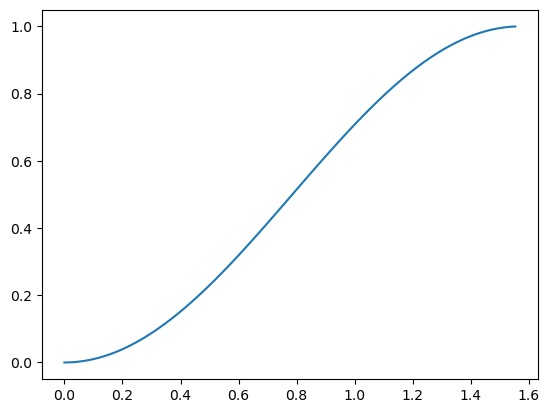

nan nan


/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_24506/288898009.py:12: RuntimeWarning: invalid value encountered in arccos
  lats = np.arccos(np.sqrt(epsilon_1)*np.sin(2*np.pi*epsilon_2))
/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_24506/288898009.py:13: RuntimeWarning: invalid value encountered in sqrt
  longs = np.arcsin(np.sqrt((epsilon_1*(np.cos(2*np.pi*epsilon_2)**2)/(1-epsilon_1*(np.sin(2*np.pi*epsilon_2)**2)))))


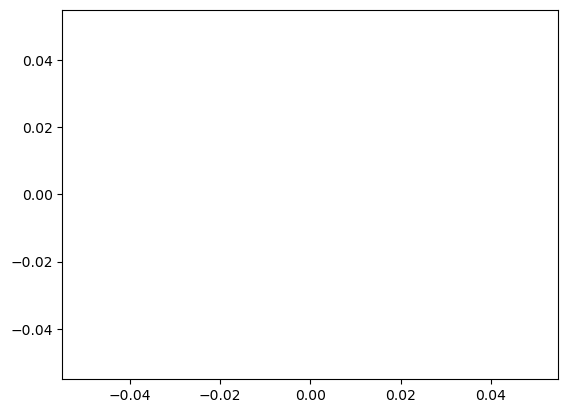

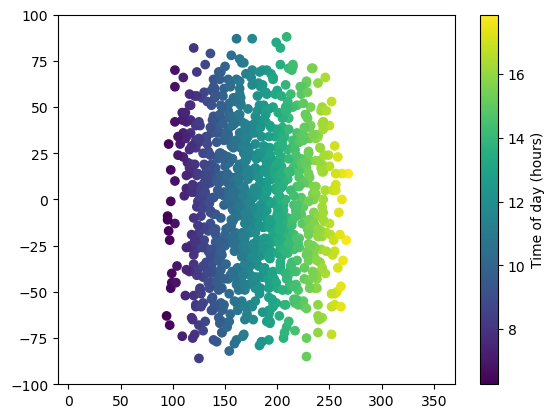

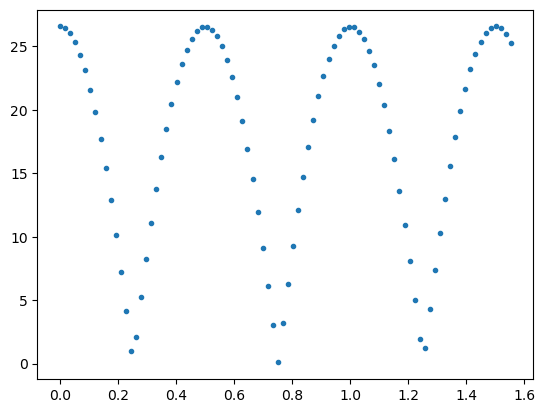

/var/folders/8b/58p6cy2n6_5dxsjpc6f4kp580000gn/T/ipykernel_24506/1026614395.py:15: RuntimeWarning: invalid value encountered in arcsin
  dlongs = np.rad2deg(np.arcsin(np.sqrt((epsilon_1[i]*(np.cos(2*np.pi*epsilon_2)**2)/(1-epsilon_1[i]*(np.sin(2*np.pi*epsilon_2)**2))))))


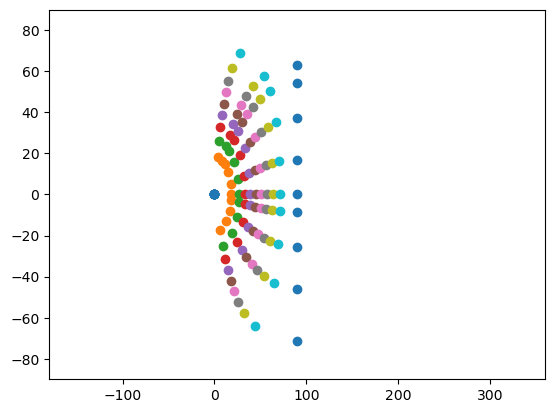